In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
# from process_results import process_results, aggregate_results, best_ridge
from scipy.stats import ortho_group

import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)


In [2]:
def loc_calc_thetahat(l):
    inv = npl.pinv(X_train.T @ X_train + l * np.eye(d))
#     inv = eigenvecs @ npl.pinv(np.eye(d) + np.diag(eigenvals)) @ eigenvecs.T
    return inv @ X_train.T @ y_train

def loc_mdl1_loss(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return (mse_norm + theta_norm + eigensum) / n


def loc_mdl1_loss_ret_all(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return mse_norm/n , theta_norm/n,  eigensum / n

def g(a, b):
    val = np.sqrt(a*(1+np.sqrt(b))**2+1)
    val -= np.sqrt(a*(1-np.sqrt(b))**2+1)
    val = val**2
    return(val/4)

def thm3(gammas, snr):
    delta = g(snr, gammas)
    bnd = gammas * np.log(1+snr-delta)
    bnd += np.log(1+gammas * snr - delta)
    bnd -= delta/snr
    return(bnd)

In [3]:
cs=sns.color_palette()

## Load Results

In [4]:
file_name = 'mdl_results_d_100_200.txt'
file = open(file_name, 'rb')
results = pickle.load(file)
# results

## Plot results

In [5]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 10
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 12
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

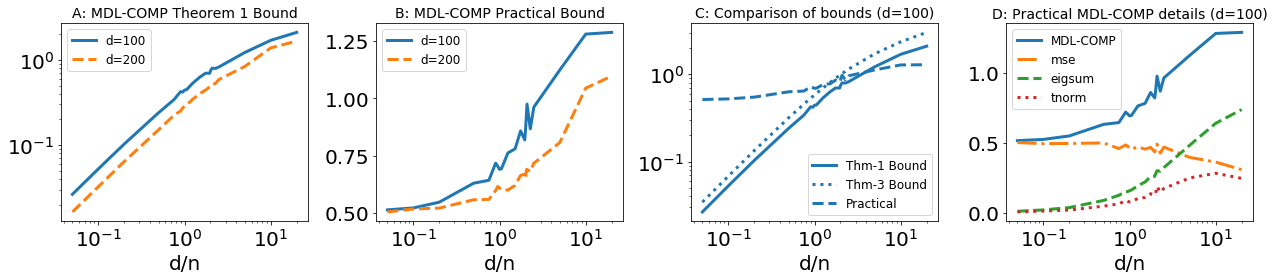

In [6]:
ds = results["ds"]
gammas = results["gammas"]
mdl_theory = results["mdl_theory"]
mdl_practice = results["mdl_practice"]
thm3_bnds = results["mdl_thm_3"]
mse = results["mse"]
eigsum = results["eigsum"]
tnorm = results["tnorm"]

plt.figure(figsize=[18, 4])

lss = ['-', '--', '-.', ':']
plt.subplot(1, 4, 1)
for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.plot(d/ns, mdl_theory.mean(0)[j, :], color=cs[j], linestyle=lss[j],linewidth=3.,  label='d=%d'%(d))
plt.legend()
plt.title('A: MDL-COMP Theorem 1 Bound')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')

plt.subplot(1, 4, 2)
for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.plot(d/ns, mdl_practice.mean(0)[j, :], color=cs[j], linestyle=lss[j],linewidth=3.,  label='d=%d'%(d))
plt.title('B: MDL-COMP Practical Bound')
plt.xscale('log')
plt.legend()
plt.xlabel('d/n')

plt.subplot(1, 4, 3)
d = ds[0]
ns = np.asarray(d/gammas, dtype=int)
plt.plot(d/ns, mdl_theory.mean(0)[0, :], color=cs[0], linestyle='-',linewidth=3.,  label='Thm-1 Bound')
plt.plot(d/ns, thm3_bnds[d], color=cs[0], linestyle=':',linewidth=3.,  label='Thm-3 Bound')
plt.plot(d/ns, mdl_practice.mean(0)[0, :], color=cs[0], linestyle='--',linewidth=3.,  label='Practical')
plt.legend()
plt.title('C: Comparison of bounds (d=%d)'%d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')


plt.subplot(1, 4, 4)
plt.plot(d/ns, mdl_practice.mean(0)[0, :], color=cs[0], linestyle='-', linewidth=3.,label='MDL-COMP')
plt.plot(d/ns, mse.mean(0)[0, :], color=cs[1], linestyle='-.', linewidth=3.,label='mse')
plt.plot(d/ns, eigsum.mean(0)[0, :], color=cs[2], linestyle='--',linewidth=3.,  label='eigsum')
plt.plot(d/ns, tnorm.mean(0)[0, :], color=cs[3], linestyle=':',  linewidth=3., label='tnorm')
plt.xscale('log')
plt.xlabel('d/n')
plt.title('D: Practical MDL-COMP details (d=%d)'%d)
plt.legend()
plt.tight_layout()
plt.savefig('mdl_comparison.pdf')
plt.show()



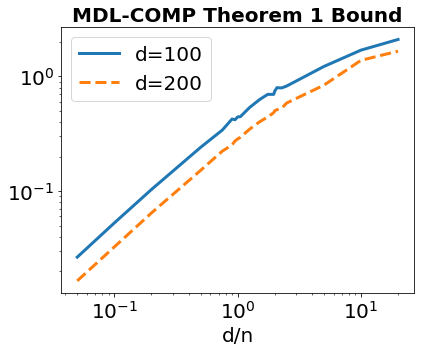

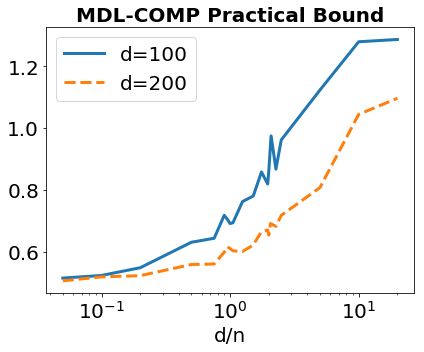

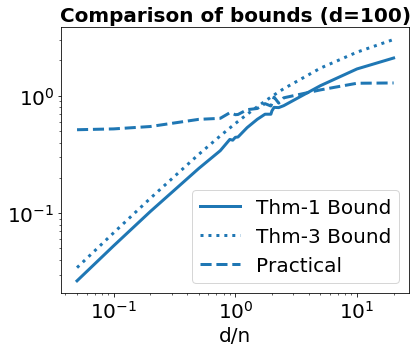

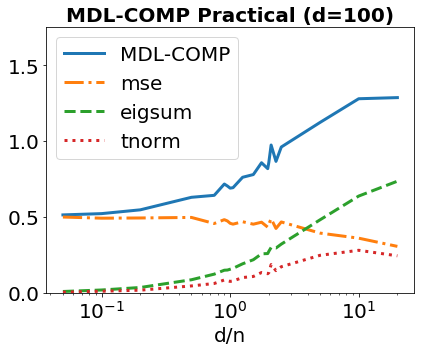

In [19]:
# ds = results["ds"]
# gammas = results["gammas"]
# mdl_theory = results["mdl_theory"]
# mdl_practice = results["mdl_practice"]
# thm3_bnds = results["mdl_thm_3"]
# mse = results["mse"]
# eigsum = results["eigsum"]
# tnorm = results["tnorm"]

# plt.figure(figsize=[5, 5])

mpl.rcParams['legend.fontsize'] = 20
lss = ['-', '--', '-.', ':']
plt.figure(figsize=[6, 5])
for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.plot(d/ns, mdl_theory.mean(0)[j, :], color=cs[j], linestyle=lss[j],linewidth=3.,  label='d=%d'%(d))
plt.legend()
plt.title('MDL-COMP Theorem 1 Bound', fontweight='bold', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')
plt.tight_layout()
plt.savefig('mdl_theory.pdf')
plt.show()

plt.figure(figsize=[6, 5])
for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.plot(d/ns, mdl_practice.mean(0)[j, :], color=cs[j], linestyle=lss[j],linewidth=3.,  label='d=%d'%(d))
plt.title('MDL-COMP Practical Bound', fontweight='bold', fontsize=20)
plt.xscale('log')
plt.legend()
plt.xlabel('d/n')
plt.tight_layout()
plt.savefig('mdl_practical.pdf')
plt.show()


plt.figure(figsize=[6, 5])
d = ds[0]
ns = np.asarray(d/gammas, dtype=int)
plt.plot(d/ns, mdl_theory.mean(0)[0, :], color=cs[0], linestyle='-',linewidth=3.,  label='Thm-1 Bound')
plt.plot(d/ns, thm3_bnds[d], color=cs[0], linestyle=':',linewidth=3.,  label='Thm-3 Bound')
plt.plot(d/ns, mdl_practice.mean(0)[0, :], color=cs[0], linestyle='--',linewidth=3.,  label='Practical')
plt.legend()
plt.title('Comparison of bounds (d=%d)'%d, fontweight='bold', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')
plt.tight_layout()
plt.savefig('mdl_comparison_all_bounds.pdf')
plt.show()



plt.figure(figsize=[6, 5])
plt.plot(d/ns, mdl_practice.mean(0)[0, :], color=cs[0], linestyle='-', linewidth=3.,label='MDL-COMP')
plt.plot(d/ns, mse.mean(0)[0, :], color=cs[1], linestyle='-.', linewidth=3.,label='mse')
plt.plot(d/ns, eigsum.mean(0)[0, :], color=cs[2], linestyle='--',linewidth=3.,  label='eigsum')
plt.plot(d/ns, tnorm.mean(0)[0, :], color=cs[3], linestyle=':',  linewidth=3., label='tnorm')
plt.xscale('log')
plt.xlabel('d/n')
plt.ylim([0., 1.75])
plt.title('MDL-COMP Practical (d=%d)'%d, fontweight='bold', fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('mdl_practical_details.pdf')
plt.show()



## Run simulations

In [74]:
num_trials = 10
gamma_inv = np.array([5e-2, 1e-1, 0.5, 0.75, 0.9, 1,
                                  1.2, 1.5, 2, 5, 7.5, 1e1, 2e1, 4e1])

gammas = np.array([5e-2, 1e-1, 0.2, 0.5, 0.75, 0.9, 0.95, 1.,  1.05,  1.25, 1.5,  1.75, 1.95, 2., 2.05, 2.25, 2.5, 5., 10., 20.])

noise_std = 0.1
n_test = 1000

ds = [100, 200]
ns = np.asarray(ds[0]/gammas, dtype=int)

mdl_practice = np.zeros((num_trials,  len(ds), len(ns)))
mdl_theory = np.zeros((num_trials, len(ds), len(ns)))
mdl_theory_mean = np.zeros((num_trials, len(ds), len(ns)))
mdl_theory_lam  = np.zeros((num_trials, len(ds), len(ns)))
mse = np.zeros((num_trials, len(ds), len(ns)))
tnorm = np.zeros((num_trials, len(ds), len(ns)))
eigsum = np.zeros((num_trials, len(ds), len(ns)))
mse_test = np.zeros((num_trials, len(ds), len(ns)))

for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    for k, n in enumerate(ns):
        print(d, n)
        X_train = npr.randn(n, d) / np.sqrt(n)
        X_test = npr.randn(n_test, d)
        eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
        
        for i in tqdm(range(num_trials)):
            
            beta_star = npr.randn(d)
            beta_star /= npl.norm(beta_star)    
            beta_star *= 1. #

            w = eigenvecs.T  @ beta_star
            
            y_train = X_train @ beta_star + noise_std * npr.randn(n)
            y_test =  X_test @ beta_star # + noise_std *  npr.randn(n_test)

            var = noise_std**2
            opt_solved = minimize(loc_mdl1_loss, x0=1e-10)
            lambda_opt = opt_solved.x
            
            mdl_practice[i, j, k] = opt_solved.fun
            mdl_theory[i, j, k] = np.sum(np.log(1+ eigenvals * w**2 / var)) / n
            mdl_theory_mean[i, j, k] = np.sum(np.log(1+ eigenvals * np.mean(w**2) /var)) / n
            mdl_theory_lam[i, j, k] = np.sum(np.log(1+ eigenvals / lambda_opt)) / n
            mse[i, j, k], tnorm[i, j, k], eigsum[i, j, k] = loc_mdl1_loss_ret_all(lambda_opt)
            
            mse_test[i, j, k] = npl.norm(y_test- X_test @ loc_calc_thetahat(lambda_opt))**2 / n_test






  0%|          | 0/10 [00:00<?, ?it/s]

100 2000







 10%|█         | 1/10 [00:00<00:07,  1.17it/s]




 20%|██        | 2/10 [00:01<00:06,  1.19it/s]




 30%|███       | 3/10 [00:02<00:05,  1.21it/s]




 40%|████      | 4/10 [00:03<00:04,  1.22it/s]




 50%|█████     | 5/10 [00:04<00:04,  1.23it/s]




 60%|██████    | 6/10 [00:04<00:03,  1.24it/s]




 70%|███████   | 7/10 [00:05<00:02,  1.24it/s]




 80%|████████  | 8/10 [00:06<00:01,  1.25it/s]




 90%|█████████ | 9/10 [00:07<00:00,  1.26it/s]




100%|██████████| 10/10 [00:08<00:00,  1.26it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 1000







 10%|█         | 1/10 [00:00<00:05,  1.64it/s]




 20%|██        | 2/10 [00:01<00:04,  1.63it/s]




 30%|███       | 3/10 [00:01<00:04,  1.63it/s]




 40%|████      | 4/10 [00:02<00:03,  1.63it/s]




 50%|█████     | 5/10 [00:03<00:03,  1.63it/s]




 60%|██████    | 6/10 [00:03<00:02,  1.65it/s]




 70%|███████   | 7/10 [00:04<00:01,  1.64it/s]




 80%|████████  | 8/10 [00:04<00:01,  1.64it/s]




 90%|█████████ | 9/10 [00:05<00:00,  1.64it/s]




100%|██████████| 10/10 [00:06<00:00,  1.65it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 500







 10%|█         | 1/10 [00:00<00:04,  1.93it/s]




 20%|██        | 2/10 [00:01<00:04,  1.93it/s]




 30%|███       | 3/10 [00:01<00:03,  1.94it/s]




 40%|████      | 4/10 [00:02<00:03,  1.93it/s]




 50%|█████     | 5/10 [00:02<00:02,  1.92it/s]




 60%|██████    | 6/10 [00:03<00:02,  1.93it/s]




 70%|███████   | 7/10 [00:03<00:01,  1.94it/s]




 80%|████████  | 8/10 [00:04<00:01,  1.95it/s]




 90%|█████████ | 9/10 [00:04<00:00,  1.96it/s]




100%|██████████| 10/10 [00:05<00:00,  1.96it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 200







 10%|█         | 1/10 [00:00<00:03,  2.27it/s]




 20%|██        | 2/10 [00:00<00:03,  2.27it/s]




 30%|███       | 3/10 [00:01<00:03,  2.24it/s]




 40%|████      | 4/10 [00:01<00:02,  2.23it/s]




 50%|█████     | 5/10 [00:02<00:02,  2.24it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.24it/s]




 70%|███████   | 7/10 [00:03<00:01,  2.23it/s]




 80%|████████  | 8/10 [00:03<00:00,  2.22it/s]




 90%|█████████ | 9/10 [00:04<00:00,  2.22it/s]




100%|██████████| 10/10 [00:04<00:00,  2.20it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 133







 10%|█         | 1/10 [00:00<00:03,  2.40it/s]




 20%|██        | 2/10 [00:00<00:03,  2.38it/s]




 30%|███       | 3/10 [00:01<00:02,  2.36it/s]




 40%|████      | 4/10 [00:01<00:02,  2.37it/s]




 50%|█████     | 5/10 [00:02<00:02,  2.34it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.33it/s]




 70%|███████   | 7/10 [00:02<00:01,  2.33it/s]




 80%|████████  | 8/10 [00:03<00:00,  2.33it/s]




 90%|█████████ | 9/10 [00:03<00:00,  2.32it/s]




100%|██████████| 10/10 [00:04<00:00,  2.32it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 111







 10%|█         | 1/10 [00:00<00:03,  2.56it/s]




 20%|██        | 2/10 [00:00<00:03,  2.53it/s]




 30%|███       | 3/10 [00:01<00:02,  2.53it/s]




 40%|████      | 4/10 [00:01<00:02,  2.52it/s]




 50%|█████     | 5/10 [00:01<00:01,  2.50it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]




 70%|███████   | 7/10 [00:02<00:01,  2.47it/s]




 80%|████████  | 8/10 [00:03<00:00,  2.45it/s]




 90%|█████████ | 9/10 [00:03<00:00,  2.43it/s]




100%|██████████| 10/10 [00:04<00:00,  2.43it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 105







 10%|█         | 1/10 [00:00<00:03,  2.51it/s]




 20%|██        | 2/10 [00:00<00:03,  2.47it/s]




 30%|███       | 3/10 [00:01<00:02,  2.47it/s]




 40%|████      | 4/10 [00:01<00:02,  2.46it/s]




 50%|█████     | 5/10 [00:02<00:02,  2.45it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.44it/s]




 70%|███████   | 7/10 [00:02<00:01,  2.44it/s]




 80%|████████  | 8/10 [00:03<00:00,  2.45it/s]




 90%|█████████ | 9/10 [00:03<00:00,  2.46it/s]




100%|██████████| 10/10 [00:04<00:00,  2.45it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 100







 10%|█         | 1/10 [00:00<00:03,  2.83it/s]




 20%|██        | 2/10 [00:00<00:02,  2.74it/s]




 30%|███       | 3/10 [00:01<00:02,  2.85it/s]




 40%|████      | 4/10 [00:01<00:02,  2.80it/s]




 50%|█████     | 5/10 [00:01<00:01,  2.80it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.83it/s]




 70%|███████   | 7/10 [00:02<00:01,  2.80it/s]




 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]




 90%|█████████ | 9/10 [00:03<00:00,  2.83it/s]




100%|██████████| 10/10 [00:03<00:00,  2.85it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 95


/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: ComplexWarning: Casting complex values to real discards the imaginary part





 10%|█         | 1/10 [00:00<00:03,  2.53it/s]




 20%|██        | 2/10 [00:00<00:03,  2.51it/s]




 30%|███       | 3/10 [00:01<00:02,  2.51it/s]




 40%|████      | 4/10 [00:01<00:02,  2.60it/s]




 50%|█████     | 5/10 [00:01<00:01,  2.59it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.57it/s]




 70%|███████   | 7/10 [00:02<00:01,  2.57it/s]




 80%|█

100 80







 10%|█         | 1/10 [00:00<00:03,  2.87it/s]




 20%|██        | 2/10 [00:00<00:02,  2.84it/s]




 30%|███       | 3/10 [00:01<00:02,  2.82it/s]




 40%|████      | 4/10 [00:01<00:02,  2.83it/s]




 50%|█████     | 5/10 [00:01<00:01,  2.81it/s]




 60%|██████    | 6/10 [00:02<00:01,  2.80it/s]




 70%|███████   | 7/10 [00:02<00:01,  2.79it/s]




 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]




 90%|█████████ | 9/10 [00:03<00:00,  2.78it/s]




100%|██████████| 10/10 [00:03<00:00,  2.79it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 66







 10%|█         | 1/10 [00:00<00:02,  3.07it/s]




 20%|██        | 2/10 [00:00<00:02,  3.09it/s]




 30%|███       | 3/10 [00:00<00:02,  3.08it/s]




 40%|████      | 4/10 [00:01<00:01,  3.08it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.08it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.07it/s]




 70%|███████   | 7/10 [00:02<00:00,  3.09it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.09it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.08it/s]




100%|██████████| 10/10 [00:03<00:00,  3.06it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 57







 10%|█         | 1/10 [00:00<00:02,  3.38it/s]




 20%|██        | 2/10 [00:00<00:02,  3.34it/s]




 30%|███       | 3/10 [00:00<00:02,  3.34it/s]




 40%|████      | 4/10 [00:01<00:01,  3.28it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.29it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.30it/s]




 70%|███████   | 7/10 [00:02<00:00,  3.03it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.07it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.15it/s]




100%|██████████| 10/10 [00:03<00:00,  3.20it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 51







 10%|█         | 1/10 [00:00<00:02,  3.48it/s]




 20%|██        | 2/10 [00:00<00:02,  3.44it/s]




 30%|███       | 3/10 [00:00<00:02,  3.42it/s]




 40%|████      | 4/10 [00:01<00:01,  3.42it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.41it/s]




 70%|███████   | 7/10 [00:02<00:00,  3.41it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.40it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.39it/s]




100%|██████████| 10/10 [00:02<00:00,  3.40it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 50







 10%|█         | 1/10 [00:00<00:02,  3.45it/s]




 20%|██        | 2/10 [00:00<00:02,  3.43it/s]




 30%|███       | 3/10 [00:00<00:02,  3.43it/s]




 40%|████      | 4/10 [00:01<00:01,  3.41it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.42it/s]




 70%|███████   | 7/10 [00:02<00:00,  3.44it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.45it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.43it/s]




100%|██████████| 10/10 [00:02<00:00,  3.44it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 48







 10%|█         | 1/10 [00:00<00:02,  3.54it/s]




 20%|██        | 2/10 [00:00<00:02,  3.52it/s]




 30%|███       | 3/10 [00:00<00:01,  3.51it/s]




 40%|████      | 4/10 [00:01<00:01,  3.50it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.48it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.48it/s]




 70%|███████   | 7/10 [00:02<00:00,  3.48it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.51it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.50it/s]




100%|██████████| 10/10 [00:02<00:00,  3.50it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 44







 10%|█         | 1/10 [00:00<00:02,  3.58it/s]




 20%|██        | 2/10 [00:00<00:02,  3.55it/s]




 30%|███       | 3/10 [00:00<00:01,  3.53it/s]




 40%|████      | 4/10 [00:01<00:01,  3.53it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.52it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.50it/s]




 70%|███████   | 7/10 [00:01<00:00,  3.51it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.51it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.49it/s]




100%|██████████| 10/10 [00:02<00:00,  3.48it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 40







 10%|█         | 1/10 [00:00<00:02,  3.72it/s]




 20%|██        | 2/10 [00:00<00:02,  3.68it/s]




 30%|███       | 3/10 [00:00<00:01,  3.68it/s]




 40%|████      | 4/10 [00:01<00:01,  3.67it/s]




 50%|█████     | 5/10 [00:01<00:01,  3.68it/s]




 60%|██████    | 6/10 [00:01<00:01,  3.68it/s]




 70%|███████   | 7/10 [00:01<00:00,  3.68it/s]




 80%|████████  | 8/10 [00:02<00:00,  3.67it/s]




 90%|█████████ | 9/10 [00:02<00:00,  3.67it/s]




100%|██████████| 10/10 [00:02<00:00,  3.67it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 20







 10%|█         | 1/10 [00:00<00:02,  4.44it/s]




 20%|██        | 2/10 [00:00<00:01,  4.44it/s]




 30%|███       | 3/10 [00:00<00:01,  4.41it/s]




 40%|████      | 4/10 [00:00<00:01,  4.42it/s]




 50%|█████     | 5/10 [00:01<00:01,  4.37it/s]




 60%|██████    | 6/10 [00:01<00:00,  4.34it/s]




 70%|███████   | 7/10 [00:01<00:00,  4.38it/s]




 80%|████████  | 8/10 [00:01<00:00,  4.38it/s]




 90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]




100%|██████████| 10/10 [00:02<00:00,  4.37it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 10







 10%|█         | 1/10 [00:00<00:01,  4.99it/s]




 20%|██        | 2/10 [00:00<00:01,  4.91it/s]




 30%|███       | 3/10 [00:00<00:01,  4.92it/s]




 40%|████      | 4/10 [00:00<00:01,  4.88it/s]




 50%|█████     | 5/10 [00:01<00:01,  4.90it/s]




 60%|██████    | 6/10 [00:01<00:00,  4.94it/s]




 70%|███████   | 7/10 [00:01<00:00,  4.98it/s]




 80%|████████  | 8/10 [00:01<00:00,  4.99it/s]




 90%|█████████ | 9/10 [00:01<00:00,  5.00it/s]




100%|██████████| 10/10 [00:02<00:00,  4.94it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

100 5







 10%|█         | 1/10 [00:00<00:01,  5.01it/s]




 20%|██        | 2/10 [00:00<00:01,  5.06it/s]




 30%|███       | 3/10 [00:00<00:01,  4.84it/s]




 40%|████      | 4/10 [00:00<00:01,  4.93it/s]




 50%|█████     | 5/10 [00:01<00:00,  5.03it/s]




 60%|██████    | 6/10 [00:01<00:00,  5.03it/s]




 70%|███████   | 7/10 [00:01<00:00,  5.04it/s]




 80%|████████  | 8/10 [00:01<00:00,  5.07it/s]




 90%|█████████ | 9/10 [00:01<00:00,  5.03it/s]




100%|██████████| 10/10 [00:01<00:00,  5.03it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

200 4000







 10%|█         | 1/10 [00:04<00:39,  4.34s/it]




 20%|██        | 2/10 [00:08<00:34,  4.34s/it]




 30%|███       | 3/10 [00:12<00:30,  4.30s/it]




 40%|████      | 4/10 [00:17<00:25,  4.27s/it]




 50%|█████     | 5/10 [00:21<00:21,  4.29s/it]




 60%|██████    | 6/10 [00:25<00:17,  4.27s/it]




 70%|███████   | 7/10 [00:29<00:12,  4.29s/it]




 80%|████████  | 8/10 [00:34<00:08,  4.29s/it]




 90%|█████████ | 9/10 [00:38<00:04,  4.30s/it]




100%|██████████| 10/10 [00:42<00:00,  4.30s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 2000







 10%|█         | 1/10 [00:02<00:26,  2.92s/it]




 20%|██        | 2/10 [00:05<00:23,  2.95s/it]




 30%|███       | 3/10 [00:08<00:20,  2.96s/it]




 40%|████      | 4/10 [00:11<00:17,  2.97s/it]




 50%|█████     | 5/10 [00:14<00:14,  2.98s/it]




 60%|██████    | 6/10 [00:17<00:11,  2.99s/it]




 70%|███████   | 7/10 [00:20<00:08,  2.99s/it]




 80%|████████  | 8/10 [00:23<00:05,  2.99s/it]




 90%|█████████ | 9/10 [00:26<00:02,  2.99s/it]




100%|██████████| 10/10 [00:29<00:00,  2.99s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 1000







 10%|█         | 1/10 [00:02<00:20,  2.32s/it]




 20%|██        | 2/10 [00:04<00:18,  2.32s/it]




 30%|███       | 3/10 [00:06<00:16,  2.32s/it]




 40%|████      | 4/10 [00:09<00:13,  2.32s/it]




 50%|█████     | 5/10 [00:11<00:11,  2.32s/it]




 60%|██████    | 6/10 [00:13<00:09,  2.32s/it]




 70%|███████   | 7/10 [00:16<00:06,  2.32s/it]




 80%|████████  | 8/10 [00:18<00:04,  2.32s/it]




 90%|█████████ | 9/10 [00:20<00:02,  2.32s/it]




100%|██████████| 10/10 [00:23<00:00,  2.34s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 400







 10%|█         | 1/10 [00:01<00:16,  1.89s/it]




 20%|██        | 2/10 [00:03<00:15,  1.94s/it]




 30%|███       | 3/10 [00:05<00:13,  1.94s/it]




 40%|████      | 4/10 [00:07<00:11,  1.92s/it]




 50%|█████     | 5/10 [00:09<00:09,  1.91s/it]




 60%|██████    | 6/10 [00:11<00:07,  1.92s/it]




 70%|███████   | 7/10 [00:13<00:05,  1.91s/it]




 80%|████████  | 8/10 [00:15<00:03,  1.92s/it]




 90%|█████████ | 9/10 [00:17<00:01,  1.91s/it]




100%|██████████| 10/10 [00:19<00:00,  1.92s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 266







 10%|█         | 1/10 [00:01<00:16,  1.81s/it]




 20%|██        | 2/10 [00:03<00:14,  1.82s/it]




 30%|███       | 3/10 [00:05<00:12,  1.82s/it]




 40%|████      | 4/10 [00:07<00:10,  1.82s/it]




 50%|█████     | 5/10 [00:09<00:09,  1.82s/it]




 60%|██████    | 6/10 [00:10<00:07,  1.82s/it]




 70%|███████   | 7/10 [00:12<00:05,  1.82s/it]




 80%|████████  | 8/10 [00:14<00:03,  1.81s/it]




 90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]




100%|██████████| 10/10 [00:18<00:00,  1.81s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 222







 10%|█         | 1/10 [00:01<00:15,  1.73s/it]




 20%|██        | 2/10 [00:03<00:13,  1.72s/it]




 30%|███       | 3/10 [00:05<00:11,  1.71s/it]




 40%|████      | 4/10 [00:06<00:10,  1.71s/it]




 50%|█████     | 5/10 [00:08<00:08,  1.70s/it]




 60%|██████    | 6/10 [00:10<00:06,  1.71s/it]




 70%|███████   | 7/10 [00:11<00:05,  1.70s/it]




 80%|████████  | 8/10 [00:13<00:03,  1.71s/it]




 90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]




100%|██████████| 10/10 [00:17<00:00,  1.70s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 210







 10%|█         | 1/10 [00:01<00:15,  1.71s/it]




 20%|██        | 2/10 [00:03<00:13,  1.71s/it]




 30%|███       | 3/10 [00:05<00:12,  1.71s/it]




 40%|████      | 4/10 [00:06<00:10,  1.71s/it]




 50%|█████     | 5/10 [00:08<00:08,  1.70s/it]




 60%|██████    | 6/10 [00:10<00:06,  1.70s/it]




 70%|███████   | 7/10 [00:11<00:05,  1.69s/it]




 80%|████████  | 8/10 [00:13<00:03,  1.69s/it]




 90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]




100%|██████████| 10/10 [00:17<00:00,  1.70s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 200







 10%|█         | 1/10 [00:01<00:13,  1.51s/it]




 20%|██        | 2/10 [00:03<00:12,  1.54s/it]




 30%|███       | 3/10 [00:04<00:10,  1.55s/it]




 40%|████      | 4/10 [00:06<00:09,  1.54s/it]




 50%|█████     | 5/10 [00:07<00:07,  1.54s/it]




 60%|██████    | 6/10 [00:09<00:06,  1.57s/it]




 70%|███████   | 7/10 [00:10<00:04,  1.57s/it]




 80%|████████  | 8/10 [00:12<00:03,  1.56s/it]




 90%|█████████ | 9/10 [00:14<00:01,  1.60s/it]




100%|██████████| 10/10 [00:15<00:00,  1.61s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 190







 10%|█         | 1/10 [00:01<00:15,  1.69s/it]




 20%|██        | 2/10 [00:03<00:13,  1.68s/it]




 30%|███       | 3/10 [00:04<00:11,  1.67s/it]




 40%|████      | 4/10 [00:06<00:09,  1.65s/it]




 50%|█████     | 5/10 [00:08<00:08,  1.65s/it]




 60%|██████    | 6/10 [00:09<00:06,  1.64s/it]




 70%|███████   | 7/10 [00:11<00:04,  1.64s/it]




 80%|████████  | 8/10 [00:13<00:03,  1.66s/it]




 90%|█████████ | 9/10 [00:14<00:01,  1.65s/it]




100%|██████████| 10/10 [00:16<00:00,  1.64s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 160







 10%|█         | 1/10 [00:01<00:13,  1.48s/it]




 20%|██        | 2/10 [00:02<00:11,  1.49s/it]




 30%|███       | 3/10 [00:04<00:10,  1.50s/it]




 40%|████      | 4/10 [00:06<00:09,  1.50s/it]




 50%|█████     | 5/10 [00:07<00:07,  1.51s/it]




 60%|██████    | 6/10 [00:09<00:06,  1.51s/it]




 70%|███████   | 7/10 [00:10<00:04,  1.51s/it]




 80%|████████  | 8/10 [00:12<00:03,  1.52s/it]




 90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]




100%|██████████| 10/10 [00:15<00:00,  1.52s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 133







 10%|█         | 1/10 [00:01<00:12,  1.40s/it]




 20%|██        | 2/10 [00:02<00:11,  1.40s/it]




 30%|███       | 3/10 [00:04<00:09,  1.41s/it]




 40%|████      | 4/10 [00:05<00:08,  1.43s/it]




 50%|█████     | 5/10 [00:07<00:07,  1.42s/it]




 60%|██████    | 6/10 [00:08<00:05,  1.41s/it]




 70%|███████   | 7/10 [00:09<00:04,  1.41s/it]




 80%|████████  | 8/10 [00:11<00:02,  1.41s/it]




 90%|█████████ | 9/10 [00:12<00:01,  1.42s/it]




100%|██████████| 10/10 [00:14<00:00,  1.41s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 114







 10%|█         | 1/10 [00:01<00:12,  1.39s/it]




 20%|██        | 2/10 [00:02<00:11,  1.40s/it]




 30%|███       | 3/10 [00:04<00:09,  1.39s/it]




 40%|████      | 4/10 [00:05<00:08,  1.39s/it]




 50%|█████     | 5/10 [00:06<00:06,  1.39s/it]




 60%|██████    | 6/10 [00:08<00:05,  1.39s/it]




 70%|███████   | 7/10 [00:09<00:04,  1.39s/it]




 80%|████████  | 8/10 [00:11<00:02,  1.38s/it]




 90%|█████████ | 9/10 [00:12<00:01,  1.38s/it]




100%|██████████| 10/10 [00:13<00:00,  1.37s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 102







 10%|█         | 1/10 [00:01<00:11,  1.31s/it]




 20%|██        | 2/10 [00:02<00:10,  1.31s/it]




 30%|███       | 3/10 [00:03<00:09,  1.31s/it]




 40%|████      | 4/10 [00:05<00:07,  1.31s/it]




 50%|█████     | 5/10 [00:06<00:06,  1.32s/it]




 60%|██████    | 6/10 [00:07<00:05,  1.32s/it]




 70%|███████   | 7/10 [00:09<00:03,  1.32s/it]




 80%|████████  | 8/10 [00:10<00:02,  1.32s/it]




 90%|█████████ | 9/10 [00:11<00:01,  1.32s/it]




100%|██████████| 10/10 [00:13<00:00,  1.32s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 100







 10%|█         | 1/10 [00:01<00:11,  1.29s/it]




 20%|██        | 2/10 [00:02<00:10,  1.30s/it]




 30%|███       | 3/10 [00:03<00:09,  1.30s/it]




 40%|████      | 4/10 [00:05<00:07,  1.30s/it]




 50%|█████     | 5/10 [00:06<00:06,  1.30s/it]




 60%|██████    | 6/10 [00:07<00:05,  1.31s/it]




 70%|███████   | 7/10 [00:09<00:03,  1.31s/it]




 80%|████████  | 8/10 [00:10<00:02,  1.30s/it]




 90%|█████████ | 9/10 [00:11<00:01,  1.32s/it]




100%|██████████| 10/10 [00:13<00:00,  1.32s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 97







 10%|█         | 1/10 [00:01<00:11,  1.30s/it]




 20%|██        | 2/10 [00:02<00:10,  1.30s/it]




 30%|███       | 3/10 [00:03<00:09,  1.30s/it]




 40%|████      | 4/10 [00:05<00:07,  1.30s/it]




 50%|█████     | 5/10 [00:06<00:06,  1.29s/it]




 60%|██████    | 6/10 [00:07<00:05,  1.28s/it]




 70%|███████   | 7/10 [00:08<00:03,  1.28s/it]




 80%|████████  | 8/10 [00:10<00:02,  1.27s/it]




 90%|█████████ | 9/10 [00:11<00:01,  1.27s/it]




100%|██████████| 10/10 [00:12<00:00,  1.27s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 88







 10%|█         | 1/10 [00:01<00:10,  1.22s/it]




 20%|██        | 2/10 [00:02<00:09,  1.22s/it]




 30%|███       | 3/10 [00:03<00:08,  1.22s/it]




 40%|████      | 4/10 [00:04<00:07,  1.23s/it]




 50%|█████     | 5/10 [00:06<00:06,  1.23s/it]




 60%|██████    | 6/10 [00:07<00:04,  1.23s/it]




 70%|███████   | 7/10 [00:08<00:03,  1.24s/it]




 80%|████████  | 8/10 [00:09<00:02,  1.24s/it]




 90%|█████████ | 9/10 [00:11<00:01,  1.24s/it]




100%|██████████| 10/10 [00:12<00:00,  1.24s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 80







 10%|█         | 1/10 [00:01<00:11,  1.23s/it]




 20%|██        | 2/10 [00:02<00:09,  1.22s/it]




 30%|███       | 3/10 [00:03<00:08,  1.23s/it]




 40%|████      | 4/10 [00:04<00:07,  1.22s/it]




 50%|█████     | 5/10 [00:06<00:06,  1.22s/it]




 60%|██████    | 6/10 [00:07<00:04,  1.22s/it]




 70%|███████   | 7/10 [00:08<00:03,  1.22s/it]




 80%|████████  | 8/10 [00:09<00:02,  1.23s/it]




 90%|█████████ | 9/10 [00:10<00:01,  1.22s/it]




100%|██████████| 10/10 [00:12<00:00,  1.22s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 40







 10%|█         | 1/10 [00:01<00:09,  1.06s/it]




 20%|██        | 2/10 [00:02<00:08,  1.06s/it]




 30%|███       | 3/10 [00:03<00:07,  1.06s/it]




 40%|████      | 4/10 [00:04<00:06,  1.06s/it]




 50%|█████     | 5/10 [00:05<00:05,  1.06s/it]




 60%|██████    | 6/10 [00:06<00:04,  1.06s/it]




 70%|███████   | 7/10 [00:07<00:03,  1.07s/it]




 80%|████████  | 8/10 [00:08<00:02,  1.07s/it]




 90%|█████████ | 9/10 [00:09<00:01,  1.06s/it]




100%|██████████| 10/10 [00:10<00:00,  1.07s/it]




  0%|          | 0/10 [00:00<?, ?it/s]

200 20







 10%|█         | 1/10 [00:00<00:08,  1.02it/s]




 20%|██        | 2/10 [00:01<00:07,  1.02it/s]




 30%|███       | 3/10 [00:02<00:06,  1.02it/s]




 40%|████      | 4/10 [00:03<00:05,  1.02it/s]




 50%|█████     | 5/10 [00:04<00:04,  1.02it/s]




 60%|██████    | 6/10 [00:05<00:03,  1.01it/s]




 70%|███████   | 7/10 [00:06<00:02,  1.01it/s]




 80%|████████  | 8/10 [00:07<00:01,  1.01it/s]




 90%|█████████ | 9/10 [00:08<00:00,  1.02it/s]




100%|██████████| 10/10 [00:09<00:00,  1.03it/s]




  0%|          | 0/10 [00:00<?, ?it/s]

200 10







 10%|█         | 1/10 [00:00<00:08,  1.06it/s]




 20%|██        | 2/10 [00:01<00:07,  1.05it/s]




 30%|███       | 3/10 [00:02<00:06,  1.06it/s]




 40%|████      | 4/10 [00:03<00:05,  1.05it/s]




 50%|█████     | 5/10 [00:04<00:04,  1.05it/s]




 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]




 70%|███████   | 7/10 [00:06<00:02,  1.04it/s]




 80%|████████  | 8/10 [00:07<00:01,  1.05it/s]




 90%|█████████ | 9/10 [00:08<00:00,  1.06it/s]




100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

In [91]:
thm3_bnds = dict()
for d in ds:
    ns = np.asarray(d/gammas, dtype=int)
    thm3_bnds[d] = thm3(d/ns, npl.norm(beta_star)/var/d)

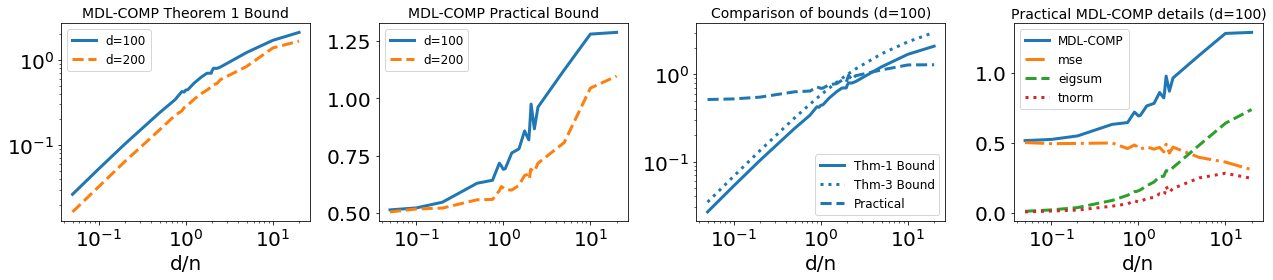

In [122]:


plt.figure(figsize=[18, 4])

lss = ['-', '--', '-.', ':']
plt.subplot(1, 4, 1)
for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.plot(d/ns, mdl_theory.mean(0)[j, :], color=cs[j], linestyle=lss[j],linewidth=3.,  label='d=%d'%(d))
plt.legend()
plt.title('MDL-COMP Theorem 1 Bound')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')

plt.subplot(1, 4, 2)
for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.plot(d/ns, mdl_practice.mean(0)[j, :], color=cs[j], linestyle=lss[j],linewidth=3.,  label='d=%d'%(d))
plt.title('MDL-COMP Practical Bound')
plt.xscale('log')
plt.legend()
plt.xlabel('d/n')

plt.subplot(1, 4, 3)
d = ds[0]
ns = np.asarray(d/gammas, dtype=int)
plt.plot(d/ns, mdl_theory.mean(0)[0, :], color=cs[0], linestyle='-',linewidth=3.,  label='Thm-1 Bound')
plt.plot(d/ns, thm3_bnds[d], color=cs[0], linestyle=':',linewidth=3.,  label='Thm-3 Bound')
plt.plot(d/ns, mdl_practice.mean(0)[0, :], color=cs[0], linestyle='--',linewidth=3.,  label='Practical')
plt.legend()
plt.title('Comparison of bounds (d=%d)'%d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('d/n')


plt.subplot(1, 4, 4)
plt.plot(d/ns, mdl_practice.mean(0)[0, :], color=cs[0], linestyle='-', linewidth=3.,label='MDL-COMP')
plt.plot(d/ns, mse.mean(0)[0, :], color=cs[1], linestyle='-.', linewidth=3.,label='mse')
plt.plot(d/ns, eigsum.mean(0)[0, :], color=cs[2], linestyle='--',linewidth=3.,  label='eigsum')
plt.plot(d/ns, tnorm.mean(0)[0, :], color=cs[3], linestyle=':',  linewidth=3., label='tnorm')
plt.xscale('log')
plt.xlabel('d/n')
plt.title('Practical MDL-COMP details (d=%d)'%d)
plt.legend()
plt.tight_layout()
plt.show()



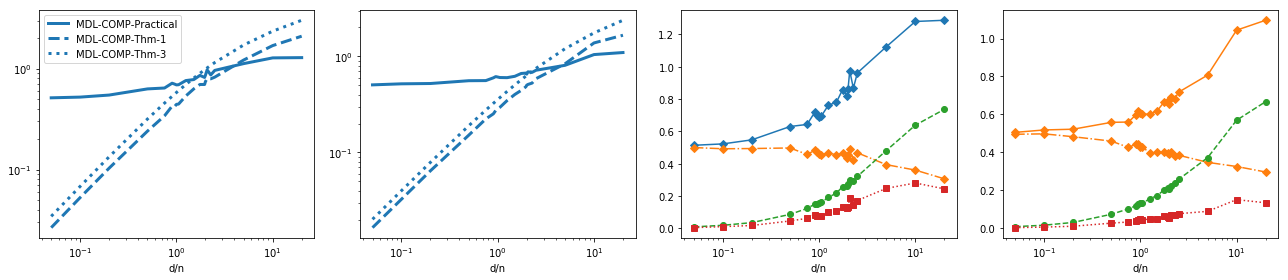

In [93]:
plt.figure(figsize=[18, 4])

for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    plt.subplot(1, 4, j+1)
    plt.plot(d/ns, mdl_practice.mean(0)[j, :], color=cs[0], linestyle='-', linewidth=3., label='Practical Bound')
    plt.plot(d/ns, mdl_theory.mean(0)[j, :], color=cs[0], linestyle='--',linewidth=3.,  label='Thm-1 Bound')
    plt.plot(d/ns, thm3_bnds[d], color=cs[0], linestyle=':',linewidth=3.,  label='Thm-3 Bound')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('d/n')
    if j==0:
        plt.legend()
    
    plt.subplot(1, 4, j+3)
    plt.plot(d/ns, mdl_practice.mean(0)[j, :], color=cs[j], linestyle='-', marker='D', label='MDL-COMP-Practical')
    plt.plot(d/ns, mse.mean(0)[j, :], color=cs[1], linestyle='-.', marker='D', label='mse')
    plt.plot(d/ns, eigsum.mean(0)[j, :], color=cs[2], linestyle='--',  marker='o', label='eigsum')
    plt.plot(d/ns, tnorm.mean(0)[j, :], color=cs[3], linestyle=':',  marker='s', label='tnorm')
#     plt.plot(d/ns, tnorm.mean(0)[j, :]+mse.mean(0)[j, :]+eigsum.mean(0)[j, :], 'k--')
    plt.xscale('log')
    plt.xlabel('d/n')
plt.tight_layout()
plt.show()
#     plt.subplot(122)
#     plt.loglog(d/ns, mdl_practice.mean(0)[j, :]/mdl_theory.mean(0)[j, :], color=cs[j])
# plt.xscale('log')
#     plt.legend()




# Dump Results

In [16]:
file_name = 'SOMETHING_NEW.txt'

In [18]:
results = {'ns': ns, 'ds': ds, 
           'num_trials': num_trials, 
           'beta_norm': npl.norm(beta_star), 
           'noise_var': noise_std**2,
           'gammas': gammas,
           'mse': mse, 
           'eigsum': eigsum, 
           'tnorm':tnorm,
           'mdl_practice': mdl_practice, 

           'mdl_theory':mdl_theory, 
           'mdl_thm_3': thm3_bnds,
           
#            'mdl_theory_lam': mdl_theory_lam, 
#            'mdl_theory_mean': mdl_theory_mean,

          }
file = open(file_name, 'wb')
pickle.dump(results, file)
file.close()